# Model Errors Distribution

In this notebook we compare different versions of the Heston MC model, and calculate model errors vs closed form solution. We run for different seeds, and plot the distribution of errors.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from finmc.calc.option import opt_price_mc

from src.models.aes import HestonAESMC
from src.models.basic import HestonMCBasic
from src.models.better import HestonMCBetter
from src.models.closed import price_vanilla_call

## Create Dataset
Create the dataset, with MC params, discounts and fwds as required by the [Dataset API](https://qablet-academy.github.io/intro/dataset/)

In [ ]:
# Rate Curve
times = np.array([0.0, 5.0])
rates = np.array([0.1, 0.1])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

# Forward Curve
ticker = "EQ"
spot = 100.0
div_rate = 0.0
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

dataset = {
    "BASE": "USD",
    "ASSETS": {"USD": discount_data, ticker: fwd_data},
    "MC": {
        "PATHS": 2_500,
        "TIMESTEP": 1 / 1000,
        "SEED": 1,
    },
    "HESTON": {
        "ASSET": ticker,
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.04,
        "VOL_OF_VOL": 0.8,
        "MEANREV": 1.0,
        "CORRELATION": -0.9,
    },
}

## Create Contract

Define a [Vanilla Option](https://qablet.github.io/qablet-contracts/examples/equity_vanilla/).

In [ ]:
# Contract Terms
strike = 100
maturity = 1.0

In [ ]:
# Create models, calculate price, and error
models = {
    "Basic": HestonMCBasic,
    "AES": HestonAESMC,
    "Better": HestonMCBetter,  # Uses Log Euler for spot, antithetic paths, and milstein discretization for vol
}

# Mean Square Errors
Run simulation with different seeds, and calculate the MSE.

In [ ]:
def plot_mse(
    models,
    ref_price,
    dataset,
    ax,
    iters=100,
):
    for model_name, model_cls in models.items():
        # for given model, price with multiple seeds, and collect errors
        errors = []
        for seed in range(1, iters):
            dataset["MC"]["SEED"] = seed
            model = model_cls(dataset)
            price = opt_price_mc(strike, maturity, "Call", ticker, model)
            errors.append(price - ref_price)

        ax.hist(
            errors,
            bins=20,
            histtype="step",
            label=model_name,
            density=True,
        )

    ax.set_title(f'timestep = {dataset["MC"]["TIMESTEP"]}')
    ax.set_xlabel("Errors")
    ax.legend()

TIMESTEP: 0.1
TIMESTEP: 0.01
TIMESTEP: 0.004


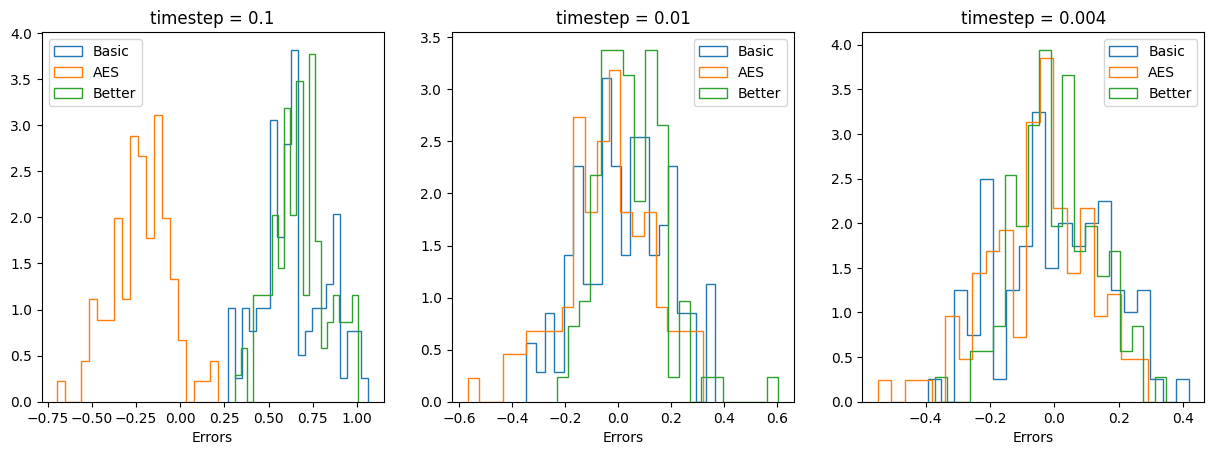

In [ ]:
# Closed form price
strike = 100
ref_price, _ = price_vanilla_call(
    strike,
    1.002,
    ticker,
    dataset,
)

# Separate plots for three different timesteps, side by side.
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(15)
timesteps = [1 / 10, 1 / 100, 1 / 250]
for ax, timestep in zip(axes, timesteps):
    print(f"TIMESTEP: {timestep}")
    dataset["MC"]["TIMESTEP"] = timestep
    plot_mse(
        models=models,
        ref_price=ref_price,
        dataset=dataset,
        ax=ax,
    )